In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'keras.utils.vis_utils'

# Dataset 1 V1 (70:30)
# EN 96%
# CNN 93%
# EFF 90%

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Define Labels

In [3]:
labels = ['Final AD JPEG','Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG','Final MCI JPEG']

In [4]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 233/233 [00:01<00:00, 135.08it/s]


In [5]:
Xtrain.shape

(18775, 150, 150, 3)

In [ ]:
Ytrain.shape

In [6]:
Xtrain,Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

## Train test split which is divided train dataset and validation dataset

In [7]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.2, random_state=42)

In [8]:
xtrain.shape

(15020, 150, 150, 3)

In [ ]:
Ytrain.shape

In [ ]:
xtest.shape

In [ ]:
ytest.shape

## Converting labels into One hot encoder

In [9]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e
                                       
ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [ ]:
ytrain.shape

In [ ]:
ytest.shape

# DENSENET MODEL

In [1]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(image_size, image_size, 3)) 

NameError: name 'DenseNet121' is not defined

In [ ]:
# Output of model

model = model_d.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(5, activation='softmax')(model)
model = tf.keras.models.Model(inputs=model_d.input, outputs=model)

In [10]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
history=model.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

In [ ]:
history = model.load_weights('/kaggle/input/model-training/Model Training/densenet.h5')

In [ ]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/DENSE.csv', index=False)

# Save the model itself
model.save('/kaggle/working/DENSE_D1_80_20.h5')

In [19]:
labels_final = ['AD','CN','EMCI','LMCI','MCI']

In [ ]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred , target_names = labels))

In [ ]:
accuracy_score(actual_label, pred)

In [ ]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,fmt="d",
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Classification using Densenet Model")
plt.savefig('densenet_confusion_97%_new2.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement graph

In [ ]:
import pickle

with open('/kaggle/input/model-training/Model Training/densenet_history.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_accuracy_97%.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Densenet Model Loss')
plt.xlabel('Epochss')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_loss_97%.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.xlabel("Epoch")
plt.xticks(range(1,21))
plt.show()

In [ ]:
# Plot the training and validation auc
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Densenet Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Densenet Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_precision.png', dpi=300) # Save plot as PNG
plt.show()

## CNN MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [ ]:
#Create the model
cnn=Sequential()
#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=(image_size, image_size, 3)))
#add a Max Pooling layer
cnn.add(MaxPooling2D())
#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Add 32 convolutions
cnn.add(Conv2D(32,(2,2),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Flatten before adding fully connected layer
cnn.add(Flatten())
#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))
#Add another hidden layer with 50 nodes
cnn.add(Dense(50,activation='relu'))
#Add final output layer with 4 output nodes using softmax
cnn.add(Dense(5,activation='softmax'))

In [ ]:
cnn.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
model1.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

In [ ]:
cnn.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

In [ ]:
history2=cnn.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

In [ ]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history1.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/CNN_D1_80_20.csv', index=False)

# Save the model itself
model.save('/kaggle/working/CNN_D1_80_20..h5')

In [ ]:
history2 = model1.load_weights('/kaggle/input/model-training/Model Training/cnn.h5')

In [ ]:
pred2 = cnn.predict(xtest)
pred2 = np.argmax(pred2, axis=1)
actual_label2 = np.argmax(ytest, axis=1)
print(classification_report(actual_label2, pred2 , target_names = labels_final))

In [ ]:
accuracy_score(actual_label2, pred2)

In [ ]:
Cm1=confusion_matrix(actual_label2,pred2)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,fmt="d",
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using CNN Model")
plt.savefig('cnn_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - CNN Model

In [ ]:
import pickle

with open('/kaggle/input/model-training/Model Training/cnn_history.pkl', 'rb') as f:
    history1 = pickle.load(f)


In [ ]:
# Plot the training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_loss.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
plt.plot(history2.history['auc'])
plt.plot(history2.history['val_auc'])
plt.title('CNN Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('CNN_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history2.history['precision'])
plt.plot(history2.history['val_precision'])
plt.title('CNN Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('CNN_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Efficient NetB7 Model

In [11]:
from tensorflow.keras.applications import EfficientNetB7

In [12]:
efficientnetB7= EfficientNetB7(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

258076736/258076736 [==============================] - 1s 0us/step


In [13]:
# Output of model

model2 = efficientnetB7.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(5, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficientnetB7.input, outputs=model2)

In [14]:
model2.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [15]:
history5=model2.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

Epoch 1/50


2023-11-20 05:27:37.711105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


470/470 [==============================] - 546s 858ms/step - loss: 0.6091 - accuracy: 0.9024 - precision: 0.7969 - recall: 0.6871 - auc: 0.9511 - val_loss: 0.3594 - val_accuracy: 0.9463 - val_precision: 0.8719 - val_recall: 0.8573 - val_auc: 0.9843
Epoch 2/50
470/470 [==============================] - 397s 845ms/step - loss: 0.3402 - accuracy: 0.9505 - precision: 0.9143 - recall: 0.8306 - auc: 0.9850 - val_loss: 0.3819 - val_accuracy: 0.9527 - val_precision: 0.8871 - val_recall: 0.8748 - val_auc: 0.9858
Epoch 3/50
470/470 [==============================] - 397s 844ms/step - loss: 0.2806 - accuracy: 0.9603 - precision: 0.9320 - recall: 0.8644 - auc: 0.9897 - val_loss: 0.2800 - val_accuracy: 0.9626 - val_precision: 0.9185 - val_recall: 0.8919 - val_auc: 0.9902
Epoch 4/50
470/470 [==============================] - 397s 846ms/step - loss: 0.2402 - accuracy: 0.9657 - precision: 0.9397 - recall: 0.8854 - auc: 0.9925 - val_loss: 0.2218 - val_accuracy: 0.9660 - val_precision: 0.9321 - val_reca

In [17]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history5.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/EFF_D1_80_20.csv', index=False)

# Save the model itself
model2.save('/kaggle/working/EFF_D1_80_20..h5')

In [ ]:
history2 = model2.load_weights('/kaggle/input/model-training/Model Training/efficientb7.h5')

In [ ]:
import pickle

with open('/kaggle/input/model-training/Model Training/efficientb7_history.pkl', 'rb') as f:
    history2 = pickle.load(f)


In [20]:
pred5 = model2.predict(xtest)
pred5 = np.argmax(pred5, axis=1)
actual_label5 = np.argmax(ytest, axis=1)
print(classification_report(actual_label5, pred5,target_names = labels_final))

118/118 [==============================] - 22s 186ms/step
              precision    recall  f1-score   support

          AD       0.99      0.92      0.95      1644
          CN       0.96      0.98      0.97      1769
        EMCI       0.88      0.81      0.84        79
        LMCI       0.75      0.67      0.71        27
         MCI       0.68      0.92      0.78       236

    accuracy                           0.94      3755
   macro avg       0.85      0.86      0.85      3755
weighted avg       0.95      0.94      0.94      3755



In [21]:
accuracy_score(actual_label5, pred5)

0.9430093209054594

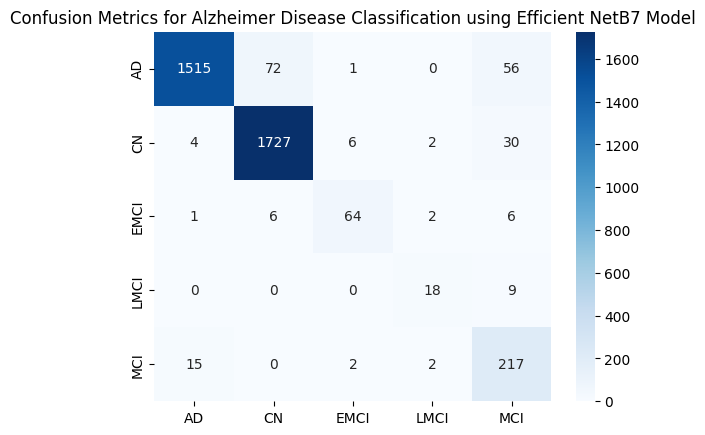

In [22]:
Cm5=confusion_matrix(actual_label5,pred5)
ax5=plt.axes()
sns.heatmap(Cm5, cmap='Blues' ,annot=True,fmt="d",
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax5
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Efficient NetB7 Model")
plt.savefig('netb7_confusion.png', dpi=300) # Save plot as PNG
plt.show()

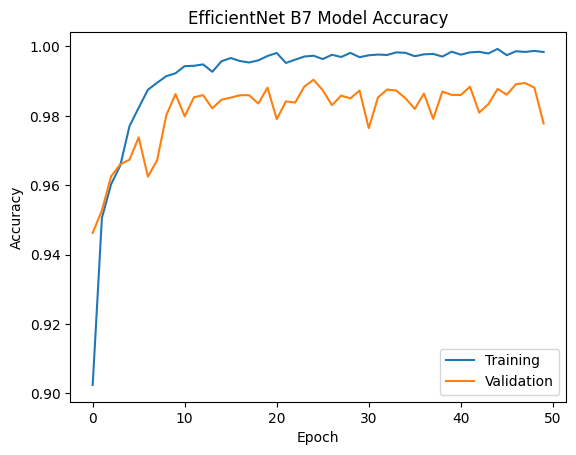

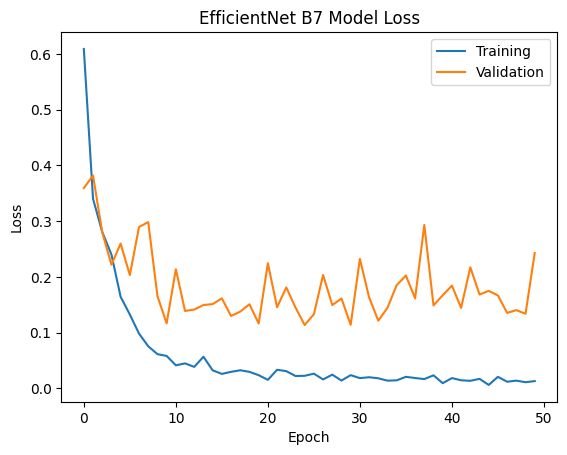

In [23]:
# Plot the training and validation accuracy
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('EfficientNet B7 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('EfficientNet B7 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_loss.png', dpi=300) # Save plot as PNG
plt.show()

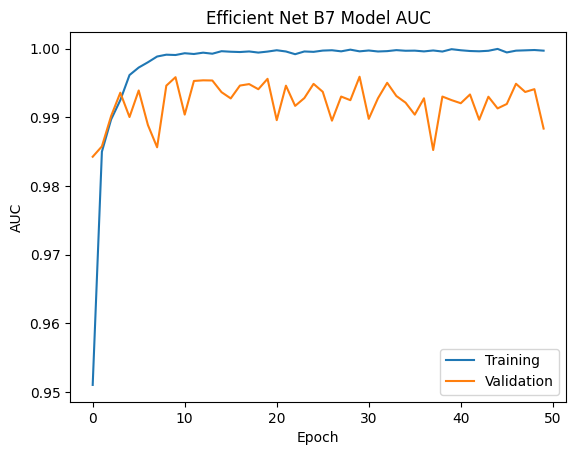

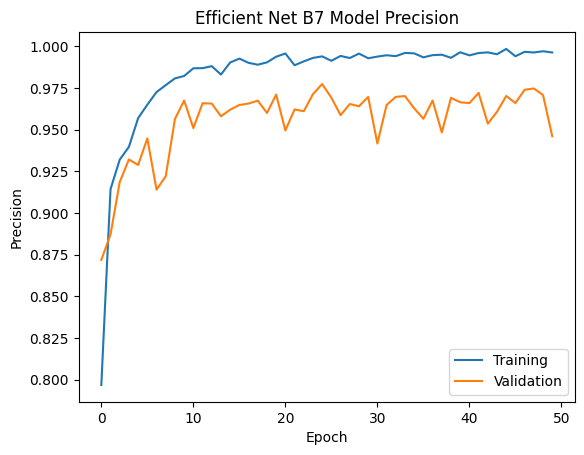

In [24]:
# Plot the training and validation auc
plt.plot(history5.history['auc'])
plt.plot(history5.history['val_auc'])
plt.title('Efficient Net B7 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_auc.png', dpi=300) # Save plot as PNG

plt.show()

# Plot the training and validation precision
plt.plot(history5.history['precision'])
plt.plot(history5.history['val_precision'])
plt.title('Efficient Net B7 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_precision.png', dpi=300) # Save plot as PNG
plt.show()

# VGG19 MODEL

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights='imagenet',
            include_top = False,input_shape=(image_size, image_size, 3)
           )
for layer in vgg.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model3 = Sequential()
model3.add(vgg)
model3.add(Flatten())
model3.add(Dense(5,activation="softmax"))
#model.summary()

## Compile VGG19 Model

In [ ]:
model3.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
model3.summary()

In [ ]:
history3=model3.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

In [ ]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history3.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/VGG_D1_80_20.csv', index=False)

# Save the model itself
model.save('/kaggle/working/VGG_D1_80_20..h5')

In [ ]:
history3 = model3.load_weights('/kaggle/input/model-training/Model Training/vgg19.h5')

In [ ]:
import pickle

with open('/kaggle/input/model-training/Model Training/vgg19_history.pkl', 'rb') as f:
    history3 = pickle.load(f)


In [ ]:
pred3 = model3.predict(xtest)
pred3 = np.argmax(pred3, axis=1)
actual_label3 = np.argmax(ytest, axis=1)
print(classification_report(actual_label3, pred3, target_names = labels_final))

In [ ]:
accuracy_score(actual_label3, pred3)

In [ ]:
Cm3=confusion_matrix(actual_label3,pred3)
ax3=plt.axes()
sns.heatmap(Cm3, cmap='Blues' ,annot=True,fmt="d",
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using VGG 19 Model")
plt.savefig('vgg19_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - VGG19 Model

In [ ]:
# Plot the training and validation accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('VGG 19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('VGG 19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_loss.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
# Plot the training and validation auc
plt.plot(history3.history['auc'])
plt.plot(history3.history['val_auc'])
plt.title('VGG 19 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history3.history['precision'])
plt.plot(history3.history['val_precision'])
plt.title('VGG 19 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_precision.png', dpi=300) # Save plot as PNG
plt.show()

ResNet 50


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
rn = ResNet50(input_shape=(150,150,3), weights='imagenet', include_top=False)

In [ ]:
for layer in rn.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model4 = Sequential()
model4.add(rn)
model4.add(Flatten())
model4.add(Dense(5,activation="softmax"))

In [ ]:
model4.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
model4.summary()

In [ ]:

history4=model4.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

## Comparison and Graphs of Different Model Types

In [ ]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history4.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/RES_D1_80_20.csv', index=False)

# Save the model itself
model.save('/kaggle/working/RES_D1_80_20.h5')

In [ ]:
pred4 = model4.predict(xtest)
pred4 = np.argmax(pred4, axis=1)
actual_label4 = np.argmax(ytest, axis=1)
print(classification_report(actual_label4, pred4 , target_names = labels_final))

In [ ]:
accuracy_score(actual_label4, pred4)

In [ ]:

Cm4=confusion_matrix(actual_label4,pred4)
ax4=plt.axes()
sns.heatmap(Cm4, cmap='Blues' ,annot=True,fmt="d",
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax4
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using ResNet50 Model")
plt.savefig('ResNet50_confusion_98%.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
# Plot the training and validation accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('ResNet-50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('ResNet-50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_loss.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
# Plot the training and validation auc
plt.plot(history4.history['auc'])
plt.plot(history4.history['val_auc'])
plt.title('ResNet-50 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history4.history['precision'])
plt.plot(history4.history['val_precision'])
plt.title('ResNet-50 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_precision.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
scores  = model.evaluate(xtest, ytest, verbose=1)
scores1 = cnn.evaluate(xtest, ytest, verbose=1)
scores2 = model2.evaluate(xtest, ytest, verbose=1)
scores3 = model3.evaluate(xtest, ytest, verbose=1)
scores4 = model4.evaluate(xtest, ytest, verbose=1)


## Densenet 

In [ ]:
precision = scores[0]
f1_score = scores[1]
recall = scores[2]
accuracy = scores[3]

## CNN 

In [ ]:
precision1 = scores1[0]
f1_score1 = scores1[1]
recall1 = scores1[2]
accuracy1 = scores1[3]

## Efficient Net B7 

In [ ]:
precision2 = scores2[0]
f1_score2 = scores2[1]
recall2 = scores2[2]
accuracy2 = scores2[3]

## VGG 19 

In [ ]:
precision3 = scores3[0]
f1_score3 = scores3[1]
recall3 = scores3[2]
accuracy3 = scores3[3]

Resnet 50


In [ ]:
precision4 = scores4[0]
f1_score4 = scores4[1]
recall4 = scores4[2]
accuracy4 = scores4[3]

In [ ]:
import pandas as pd

eval_df = pd.DataFrame(columns=['Model','Precision', 'F1 Score', 'Recall', 'Accuracy'])


In [ ]:
eval_df = eval_df.append({'Model' : 'Densenet', 'Precision': precision, 'F1 Score': f1_score, 'Recall': recall, 'Accuracy': accuracy}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'CNN', 'Precision': precision1, 'F1 Score': f1_score1, 'Recall': recall1, 'Accuracy': accuracy1}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'Efficient Net B7', 'Precision': precision2, 'F1 Score': f1_score2, 'Recall': recall2, 'Accuracy': accuracy2}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'VGG 19', 'Precision': precision3, 'F1 Score': f1_score3, 'Recall': recall3, 'Accuracy': accuracy3}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'Resnet50', 'Precision': precision4, 'F1 Score': f1_score4, 'Recall': recall4, 'Accuracy': accuracy4}, ignore_index=True)

In [ ]:
eval_df

In [ ]:
import csv
eval_df.to_csv('comparison_metrics.csv', index=False)

## Ensemble Learning

In [ ]:
pred = model.predict(xtest)
pred2=cnn.predict(xtest)
pred5 = model2.predict(xtest)
pred4=model4.predict(xtest)
pred3=model3.predict(xtest)
ensemble_preds = np.average([pred ,pred5 ,pred2 ,pred4], axis=0)
final_preds = np.argmax(ensemble_preds, axis=1)
actual_label_final = np.argmax(ytest, axis=1)
print(classification_report(actual_label_final, final_preds,target_names = labels_final))
accuracy_score(actual_label_final, final_preds)

In [ ]:
Cm5=confusion_matrix(actual_label_final,final_preds)
ax3=plt.axes()
sns.heatmap(Cm5, cmap='Blues' ,annot=True,fmt="d",
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Ensemble Model")
plt.savefig('ensemble_confusion_98%.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
import pickle
with open('/kaggle/input/model-training/Model Training/ensemble_history.pkl', 'rb') as f:
    final = pickle.load(f)

In [ ]:
# Plot the training and validation accuracy
plt.plot(final['accuracy'])
plt.plot(final['val_accuracy'])
plt.title('Ensemble Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_accuracy2_98%.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(final['loss'])
plt.plot(final['val_loss'])
plt.title('Ensemble Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_loss2_98%.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
# Plot the training and validation auc
plt.plot(final['auc'])
plt.plot(final['val_auc'])
plt.title('Ensemble Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_auc2_98%.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(final['precision'])
plt.plot(final['val_precision'])
plt.title('Ensemble Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_precision2_98%.png', dpi=300) # Save plot as PNG
plt.show()

## Mean Square Error 

In [ ]:
from sklearn.metrics import mean_squared_error

pred_final1 = (pred + pred1 + pred4 + pred2)/4.0
 
# printing the mean squared error between real value and predicted value
print(mean_squared_error(ytest, pred_final1))

## Prediction

In [ ]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model2.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "Final AD JPEG"
    elif prd == 1:
        prd = "Final CN JPEG"
    elif prd == 2:
        prd = "Final EMCI JPEG"
    elif prd == 3:
        prd = "Final LMCI JPEG"
    elif prd == 4:
        prd = "Final MCI JPEG"
    if prd!=1:
        print(f'Model Predict That is  a {prd}')
    

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

In [ ]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])
